In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import warnings
import os
from random import sample
import pickle
from sklearn.svm import SVR

warnings.filterwarnings('ignore')

## Functions

In [51]:
def save_model(model):
    filename = 'model.sav'
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    return pickle.load(open(filename, 'rb'))

In [52]:
def predict_evaluate(prediction, true, graphName = 'Energy Usage Prediction', showplots=False):
    
    diff = [abs(prediction[i]-true[i]) for i in range(len(prediction))]
    
    resultingPlot = plt.figure(figsize=(25,10))
    plt.plot(true, color='red', label='Original Usage')
    plt.plot(prediction, color='blue', label='Predicted Usage')
    #plt.plot(diff, color='green', label='Error')
    plt.title(graphName)
    plt.ylabel('kW')
    plt.legend()
    
    mape = mean_absolute_percentage_error(true, prediction)
    mae = mean_absolute_error(true, prediction)
    maxae = max(diff)
    mse = mean_squared_error(true, prediction)
    
    if showplots:
        plt.show()
        print("Mean Absolute Percentage Error: ", mape)
        print("Mean Absolute Error: ", mae)
        print("Max Absolute Error: ", maxae)
        print("Mean Squared Error: ", mse)
    
    return {"name":graphName, "resultingPlot": resultingPlot, "mape":mape, "mae":mae, "maxae":maxae, "mse":mse}

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling2D, Conv2D, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

def define_model(past_window, num_features):
    
    #OPTIMIZAVEL
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True,input_shape=(past_window, num_features)))
    model.add(LSTM(units=64))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mean_absolute_error')
    #model.summary()
    
    return model

def train(model, train_generator, showplot=False):
    early_stopping = EarlyStopping(monitor="loss", 
                                   patience=2, 
                                   mode="min")
    
    history = model.fit(train_generator, 
                                  epochs=24,
                                  shuffle = False, 
                                  callbacks=[early_stopping],
                                  verbose=0
                                   )
    
    loss_per_epoch = history.history['loss']
    
    if showplot:
        plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
        

In [54]:
directory = "../../datsets/LCL_Data_Transformed/"
allHouses = sorted(os.listdir(directory))

trainNumber = 10
testNumber = 1

testUsers = sample(allHouses, testNumber)
trainUsers = sample(allHouses, trainNumber)

featuresNames = ['use', 'hour', 'weekday']
targetName = ['use']
past_window = 24

generic_Model = define_model(past_window, len(featuresNames))

## Train generic model with multiple houses

In [55]:
for filename in trainUsers:
    print("Training with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
        features = df[featuresNames].values
        target = df[targetName].values
        
        #SCALE
        x_scaler = MinMaxScaler()
        x_train = x_scaler.fit_transform(features)

        y_scaler = MinMaxScaler()
        y_train = y_scaler.fit_transform(target)
        
        #Time series
        batch_size=64
        train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
        
        train(generic_Model, train_generator)
                
#prediction = model.predict(x_test).reshape(-1, 1)
#prediction = y_scaler.inverse_transform(prediction)

Training with  MAC000251.csv
Training with  MAC002194.csv
Training with  MAC000136.csv
Training with  MAC002150.csv
Training with  MAC002349.csv
Training with  MAC000022.csv
Training with  MAC002138.csv
Training with  MAC001220.csv
Training with  MAC001557.csv
Training with  MAC000526.csv


## Test generic model for 1 house

Testing with  MAC002112.csv


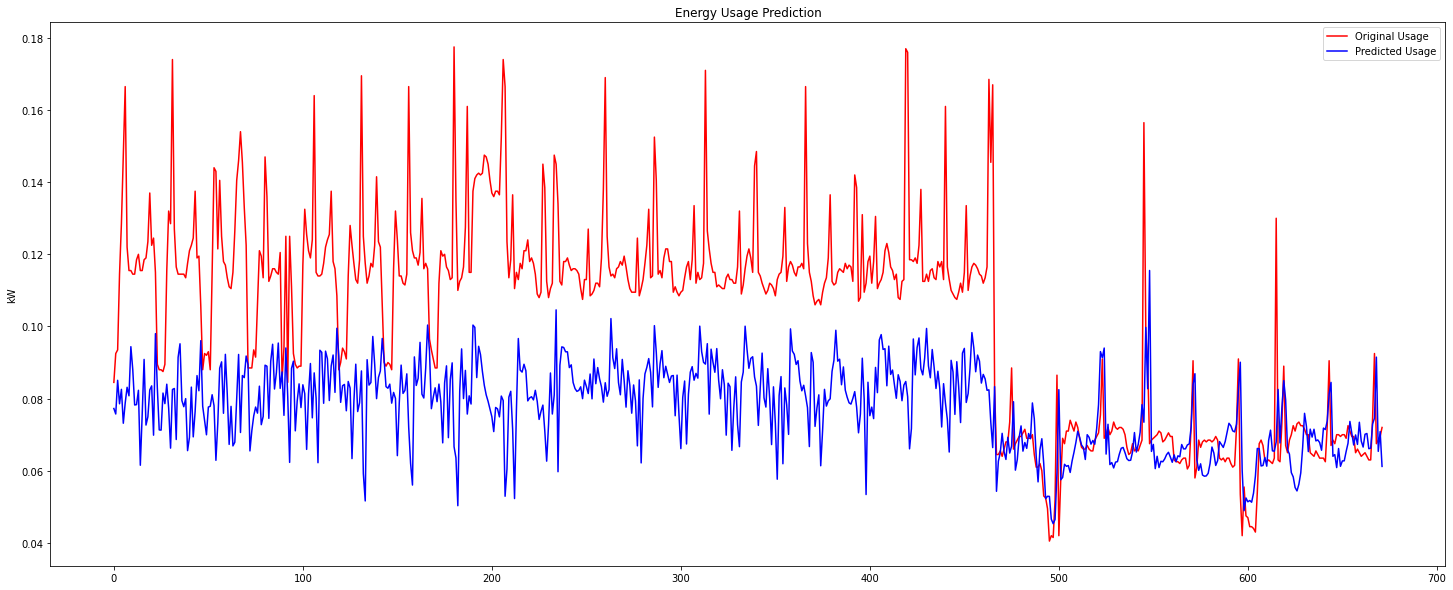

Mean Absolute Percentage Error:  0.23705365598444503
Mean Absolute Error:  0.027308943663856812
Max Absolute Error:  [0.11357095]
Mean Squared Error:  0.0011839788978848331


In [56]:
for filename in testUsers:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
    features = df[featuresNames].values[-(24*30-past_window):]
    target = df[targetName].values[-(24*30-past_window):]

    #SCALE
    x_scaler = MinMaxScaler()
    x_test = x_scaler.fit_transform(features)

    y_scaler = MinMaxScaler()
    y_test = y_scaler.fit_transform(target)

    #Time series
    batch_size=64
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)

    prediction = generic_Model.predict(test_generator).reshape(-1, 1)

    prediction = y_scaler.inverse_transform(prediction)


    predict_evaluate(prediction, target[past_window:], showplots=True)

## Case Study

In [57]:
def prepareDataSet(df, featuresNames, targetName = ["use"],past_window = 24):
    features = df[featuresNames].values   
    target = df[targetName].values.reshape(-1,1)
    
    #SCALE
    x_scaler = StandardScaler()
    x_train = x_scaler.fit_transform(features)
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(target)
    
    batch_size=1
    train_generator = TimeseriesGenerator(features, target, length=past_window, batch_size=batch_size)
    
    return train_generator

Testing with  MAC002112.csv
GENERIC--------


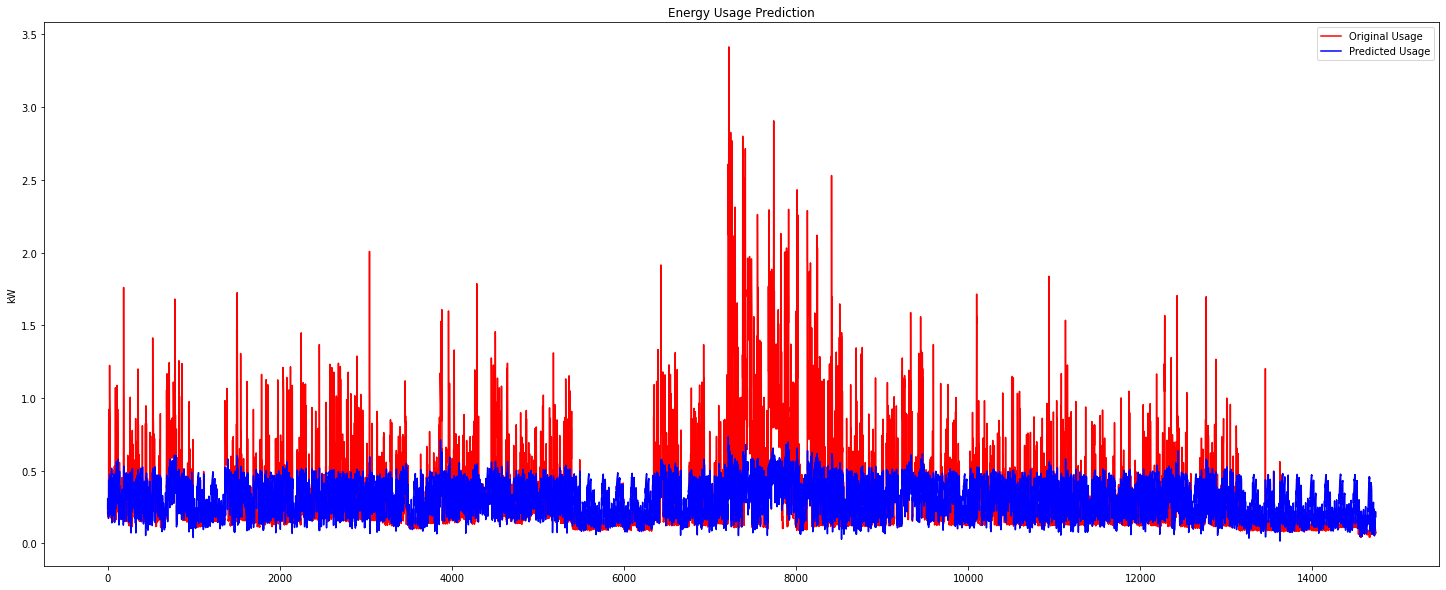

Mean Absolute Percentage Error:  0.7045130043373143
Mean Absolute Error:  0.1717613832385015
Max Absolute Error:  [2.8629045]
Mean Squared Error:  0.07409649805861257
SPECIFIC--------


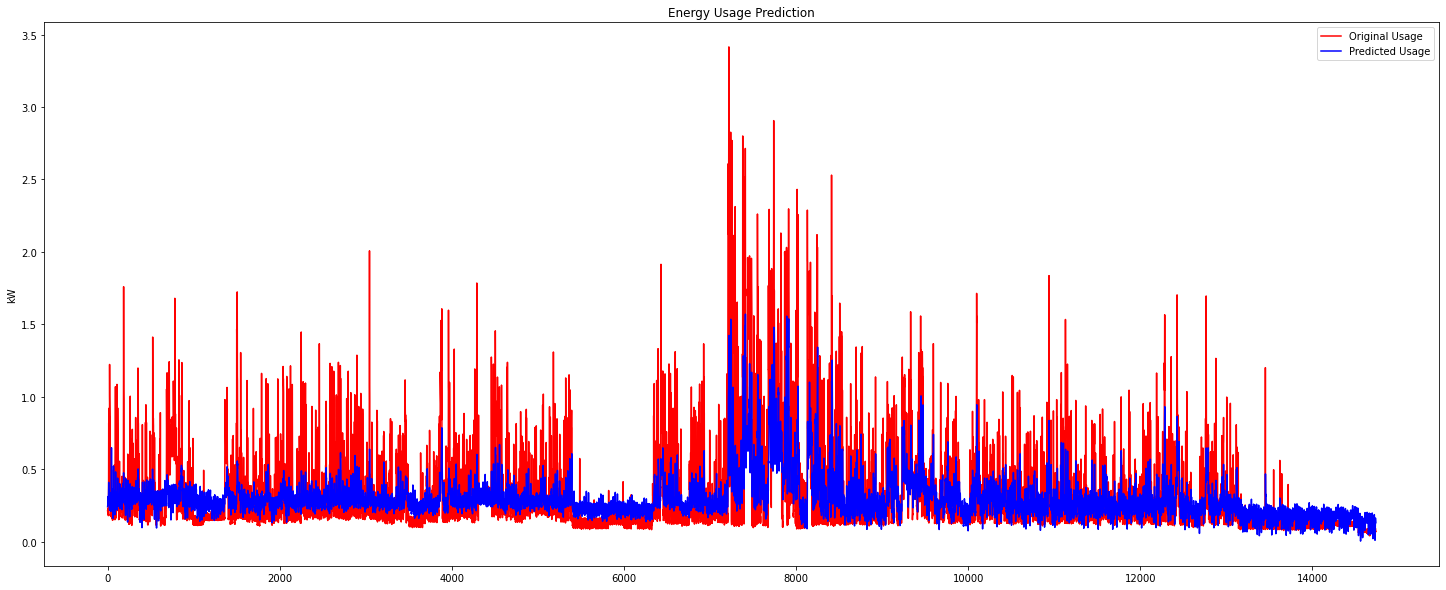

Mean Absolute Percentage Error:  0.4954691039129471
Mean Absolute Error:  0.13246719975416116
Max Absolute Error:  2.2715166375100333
Mean Squared Error:  0.04614365936257702


In [58]:

for filename in testUsers:
    print("Testing with ", filename)
    
    generic_prediction = None
    generic_preds = []

    specific_prediction = None
    specific_Model = None
    specific_preds = []
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
    features = df[featuresNames].values
    target = df[targetName].values
    
    #new dataframe step by step
    d = {key:[] for key in df.columns}
    userKnownDf = pd.DataFrame(data=d)
    
    hourIndex = 0
    true = []
    for index, row in df.iterrows():
        hourIndex += 1
        
        #Read new values
        userKnownDf = userKnownDf.append(row)
        
        if specific_Model is not None:
            
            #PREDICT NEXT
            train_generator = prepareDataSet(userKnownDf.iloc[-(past_window + 1):], featuresNames)
            x_test = [arr[0].flatten() for arr in train_generator]
        
            specific_prediction = specific_Model.predict(x_test)[0]
            generic_prediction = generic_Model.predict(train_generator)[0]    
        
            #CHECK LAST PREDICTION
            #get true value
            actualValue = row["use"]
            true.append(actualValue)
            generic_preds.append(generic_prediction)
            specific_preds.append(specific_prediction)

        #RETRAIN
        if hourIndex % (7*24) == 0:    #Every Week
            train_generator = prepareDataSet(userKnownDf, featuresNames)
            x_train = [arr[0].flatten() for arr in train_generator]
            y_train = [arr[1].flatten() for arr in train_generator]
            
            specific_Model = SVR(kernel = "rbf")
            specific_Model.fit(x_train, y_train)
        
        a = str(hourIndex) + "/" + str(len(df))
        print(a, end="\r")
    
    print("GENERIC--------")
    a = predict_evaluate(generic_preds, true, showplots=True)

    print("SPECIFIC--------")
    a = predict_evaluate(specific_preds, true, showplots=True)
        